In [189]:
path = 'temp/'

In [190]:
files = glob.glob(path+'*.csv')

In [191]:
files = files[:8]

In [192]:
files

['temp\\Cumulative Returns vs BTC (Log Scaled).csv',
 'temp\\Cumulative Returns vs BTC (Volatility Matched).csv',
 'temp\\Cumulative Returns vs BTC.csv',
 'temp\\Daily Returns.csv',
 'temp\\data_key_performance_metrics.csv',
 'temp\\data_return_vs_benchmark.csv',
 'temp\\data_worst_drawdowns.csv',
 'temp\\Distribution of Monthly Returns.csv']

In [195]:
final = {}
for file in files:
    x = pd.read_csv(file)
    x = x.to_dict(orient='list')
    final[file[len(path):-4]] = x

In [196]:
final.keys()

dict_keys(['Cumulative Returns vs BTC (Log Scaled)', 'Cumulative Returns vs BTC (Volatility Matched)', 'Cumulative Returns vs BTC', 'Daily Returns', 'data_key_performance_metrics', 'data_return_vs_benchmark', 'data_worst_drawdowns', 'Distribution of Monthly Returns'])

In [187]:
final[file].keys()

dict_keys(['time', 'returns', 'return_mean'])

In [177]:
final

{'temp\\Cumulative Returns vs BTC (Log Scaled).csv': {'time': ['2014-02-07',
   '2014-02-08',
   '2014-02-09',
   '2014-02-10',
   '2014-02-11',
   '2014-02-12',
   '2014-02-13',
   '2014-02-14',
   '2014-02-15',
   '2014-02-16',
   '2014-02-17',
   '2014-02-18',
   '2014-02-19',
   '2014-02-20',
   '2014-02-21',
   '2014-02-22',
   '2014-02-23',
   '2014-02-24',
   '2014-02-25',
   '2014-02-26',
   '2014-02-27',
   '2014-02-28',
   '2014-03-01',
   '2014-03-02',
   '2014-03-03',
   '2014-03-04',
   '2014-03-05',
   '2014-03-06',
   '2014-03-07',
   '2014-03-08',
   '2014-03-09',
   '2014-03-10',
   '2014-03-11',
   '2014-03-12',
   '2014-03-13',
   '2014-03-14',
   '2014-03-15',
   '2014-03-16',
   '2014-03-17',
   '2014-03-18',
   '2014-03-19',
   '2014-03-20',
   '2014-03-21',
   '2014-03-22',
   '2014-03-23',
   '2014-03-24',
   '2014-03-25',
   '2014-03-26',
   '2014-03-27',
   '2014-03-28',
   '2014-03-29',
   '2014-03-30',
   '2014-03-31',
   '2014-04-01',
   '2014-04-02',
   '2

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
from cryptocompy import coin,price
import tqdm

import io
import requests
import json
from datetime import datetime
import time
from time import gmtime, strftime

from sklearn import metrics
from fbprophet import Prophet
plt.rcParams["figure.figsize"] = [14,8]
pd.set_option('float_format', '{:f}'.format)

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

In [70]:
df = pd.read_csv('history.csv')
df['time'] = df['time'].apply(lambda x: x[:10])
df.set_index('time',inplace=True)

In [71]:
df.columns

Index(['Unnamed: 0', 'close', 'coin', 'high', 'low', 'open', 'volumefrom', 'volumeto'], dtype='object')

In [72]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [75]:
x = coin.get_coin_list()
x = list(x.keys())

In [87]:
coins = df['coin'].unique().tolist() + ['GXC', 'NEC'] + x[:500]

In [89]:
coins = pd.Series(coins).unique().tolist()

In [90]:
len(coins)

654

In [105]:
final = pd.DataFrame()

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d")

for c in tqdm.tqdm_notebook(coins):
    temp = df[df['coin'] == c]
    
    if len(temp) != 0:
        date_format = "%Y-%m-%d"
        a = datetime.strptime(temp.index[-1], date_format)
        b = datetime.strptime(dt_string, date_format)
        delta = b - a

        d1 = price.get_historical_data(c, 'USD', 'day', aggregate=1, limit=delta.days)
        d1 = pd.DataFrame(d1)
        if len(d1) > 0:
            d1['time'] = d1['time'].apply(lambda x: x[:10])
            d1.set_index('time',inplace=True)

            d1['coin'] = c

        d1 = pd.concat([temp,d1])
        d1 = d1[~d1.index.duplicated(keep='first')]
    else:
        d1 = price.get_historical_data(c, 'USD', 'day', aggregate=1, limit=2000)
        d1 = pd.DataFrame(d1)
        if len(d1) > 0:
            d1 = d1[d1['close']!=0]
            d1['time'] = d1['time'].apply(lambda x: x[:10])
            d1.set_index('time',inplace=True)
            d1['coin'] = c
    
    final = pd.concat([final,d1])

In [107]:
final.to_csv('history.csv')

In [111]:
benchmark = ['BTC']
ratio = [1]
tmp = pd.DataFrame()
for i in range(len(benchmark)):
    temp = final[final['coin'] == benchmark[i]]
    temp = temp['close'][temp['close'] != 0]
    temp = temp.pct_change().fillna(0) * ratio[i]
    tmp = pd.concat([tmp,pd.DataFrame(temp)], axis=1)
    tmp = tmp.sum(axis=1)

In [122]:
tmp.index

Index(['2014-02-07', '2014-02-08', '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12', '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
       ...
       '2019-08-18', '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22', '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26', '2019-08-27'], dtype='object', name='time', length=2028)

In [123]:
toke.index

Index(['2014-02-07', '2014-02-08', '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12', '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
       ...
       '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22', '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26', '2019-08-27', 'returns'], dtype='object', name='time', length=2029)

In [147]:
final

,close,coin,high,low,open,volumefrom,volumeto
time,,,,,,,
2014-02-07,695.650000,BTC,833.070000,651.730000,828.870000,49906.750000,36412212.300000
2014-02-08,648.780000,BTC,719.260000,632.080000,695.650000,22876.300000,15503790.630000
2014-02-09,659.570000,BTC,694.120000,622.530000,648.780000,19884.900000,13186251.810000
2014-02-10,582.630000,BTC,700.040000,500.040000,659.570000,40130.050000,24334044.200000
2014-02-11,578.960000,BTC,609.710000,550.220000,582.630000,16725.920000,9621820.700000
2014-02-12,531.130000,BTC,585.120000,511.900000,578.960000,21301.390000,11628634.590000
2014-02-13,451.440000,BTC,549.200000,451.330000,531.130000,28942.070000,14394464.140000
2014-02-14,427.680000,BTC,500.030000,302.180000,451.440000,65819.680000,25084223.330000
2014-02-15,371.070000,BTC,447.940000,310.080000,427.680000,50617.350000,18299075.740000


In [152]:
final['coin'].unique().tolist()

['BTC',
 'ETH',
 'AVT',
 'OMG',
 'EOS',
 'LTC',
 'USDT',
 'XMR',
 'DASH',
 'NEO',
 'ZEC',
 'BTG',
 'SNT',
 'ETP',
 'SAN',
 'FUN',
 'EDO',
 'GNO',
 'TNB',
 'BAT',
 'TRX',
 'HOT',
 'GNT',
 'BCH',
 'XRP',
 'ELF',
 'ETC',
 'QTUM',
 'CND',
 'DRGN',
 'PAY',
 'KNC',
 'AST',
 'AION',
 'UTNP',
 'FSN',
 'LSK',
 'PAI',
 'GUSD',
 'RLC',
 'MAN',
 'UTK',
 'ZRX',
 'VEE',
 'POA',
 'QASH',
 'ZIL',
 'AGI',
 'ZCN',
 'BSV',
 'XTZ',
 'MKR',
 'USDC',
 'ENJ',
 'WTC',
 'DAI',
 'LRC',
 'ZEN',
 'ODE',
 'RIF',
 'MITH',
 'CTXC',
 'TKN',
 'REQ',
 'BFT',
 'MHC',
 'ANT',
 'EDR',
 'RDN',
 'DATA',
 'THETA',
 'REP',
 'XVG',
 'MANA',
 'CAT',
 'ADA',
 'BCN',
 'NULS',
 'GBYTE',
 'CVT',
 'GRIN',
 'BEAM',
 'TNT',
 'LINK',
 'ICX',
 'KIN',
 'POWR',
 'PHX',
 'AMB',
 'FUEL',
 'QSP',
 'LEND',
 'GNX',
 'GTO',
 'QLC',
 'NGC',
 'JNT',
 'BLZ',
 'MOBI',
 'ABT',
 'LOOM',
 'ONT',
 'ELA',
 'SKM',
 'IOTX',
 'EGT',
 'QKC',
 'MET',
 'NXT',
 'BNB',
 'KMD',
 'WAVES',
 'STORJ',
 'DGTX',
 'DGD',
 'EDG',
 'AE',
 'XLM',
 'XEM',
 'DOGE',
 'DCR',


In [156]:
toke = final[final['coin'] == 'KNC']
toke = toke['close'][toke['close'] != 0]

In [158]:
toke = toke.pct_change().fillna(0)

In [160]:
qs.reports.html(toke,tmp,file='reports/'+c+'.html',c1=c,c2=c2)

1467 5


In [198]:
final = pd.read_csv('history.csv')

In [200]:
benchmark = ['BTC']
ratio = [1]

final.index = pd.to_datetime(final.index)

for c in final['coin'].unique().tolist()[0:1]:
    print(c)
    toke = final[final['coin'] == c]
    toke = toke['close'][toke['close'] != 0]
    toke = toke.pct_change().fillna(0)

    tmp = pd.DataFrame()
    for i in range(len(benchmark)):
        temp = final[final['coin'] == benchmark[i]]
        temp = temp['close'][temp['close'] != 0]
        temp = temp.pct_change().fillna(0) * ratio[i]
        tmp = pd.concat([tmp,pd.DataFrame(temp)], axis=1)
        tmp = tmp.sum(axis=1)

    c2 = "+".join(benchmark)
    qs.reports.html(toke,tmp,file='reports/'+c+'.html',c1=c,c2=c2)


BTC


ZeroDivisionError: float division by zero

In [151]:
benchmark = ['BTC']
ratio = [1]

final.index = pd.to_datetime(final.index)

for c in final['coin'].unique().tolist()[0]:
    toke = final[final['coin'] == c]
    print(toke)
    toke = toke['close'][toke['close'] != 0]
    toke = toke.pct_change().fillna(0)

    tmp = pd.DataFrame()
    for i in range(len(benchmark)):
        temp = final[final['coin'] == benchmark[i]]
        temp = temp['close'][temp['close'] != 0]
        temp = temp.pct_change().fillna(0) * ratio[i]
        tmp = pd.concat([tmp,pd.DataFrame(temp)], axis=1)
        tmp = tmp.sum(axis=1)

    c2 = "+".join(benchmark)
    qs.reports.html(toke,tmp,file='reports/'+c+'.html',c1=c,c2=c2)

Empty DataFrame
Columns: [close, coin, high, low, open, volumefrom, volumeto]
Index: []


IndexError: index 0 is out of bounds for axis 0 with size 0

In [150]:
tmp

time
2014-02-07    0.000000
2014-02-08   -0.067376
2014-02-09    0.016631
2014-02-10   -0.116652
2014-02-11   -0.006299
2014-02-12   -0.082614
2014-02-13   -0.150039
2014-02-14   -0.052632
2014-02-15   -0.132365
2014-02-16   -0.192066
2014-02-17   -0.091795
2014-02-18    0.079587
2014-02-19   -0.110291
2014-02-20   -0.572057
2014-02-21   -0.003217
2014-02-22    1.291054
2014-02-23    0.213545
2014-02-24   -0.439017
2014-02-25   -0.219655
2014-02-26    3.368390
2014-02-27    0.005648
2014-02-28   -0.037804
2014-03-01   -0.028836
2014-03-02   -0.023018
2014-03-03    0.215991
2014-03-04   -0.000498
2014-03-05   -0.005364
2014-03-06   -0.015251
2014-03-07   -0.048638
2014-03-08   -0.012193
2014-03-09    0.029284
2014-03-10   -0.022454
2014-03-11   -0.006982
2014-03-12    0.017644
2014-03-13    0.009057
2014-03-14   -0.017615
2014-03-15    0.016286
2014-03-16   -0.007836
2014-03-17   -0.020609
2014-03-18   -0.012286
2014-03-19   -0.006628
2014-03-20   -0.048692
2014-03-21   -0.028958
2014-0

In [138]:
files = glob.glob('temp/'+'*.csv')

In [139]:
files

['temp\\Cumulative Returns vs BTC (Log Scaled).csv',
 'temp\\Cumulative Returns vs BTC (Volatility Matched).csv',
 'temp\\Cumulative Returns vs BTC.csv',
 'temp\\Cumulative Returns vs EOS+BTC (Log Scaled).csv',
 'temp\\Cumulative Returns vs EOS+BTC (Volatility Matched).csv',
 'temp\\Cumulative Returns vs EOS+BTC.csv',
 'temp\\Daily Returns.csv',
 'temp\\data_key_performance_metrics.csv',
 'temp\\data_return_vs_benchmark.csv',
 'temp\\data_worst_drawdowns.csv',
 'temp\\Distribution of Monthly Returns.csv',
 'temp\\Drawdown Periods.csv',
 'temp\\EOY Returns  vs BTC.csv',
 'temp\\EOY Returns  vs EOS+BTC.csv',
 'temp\\Quantile Returns.csv',
 'temp\\Rolling Beta to BTC.csv',
 'temp\\Rolling Beta to EOS+BTC.csv',
 'temp\\Rolling Sharpe (6-Months).csv',
 'temp\\Rolling Sortino (6-Months).csv',
 'temp\\Rolling Volatility (6-Months).csv',
 'temp\\Underwater Plot.csv']

In [ ]:
os.

In [137]:
import os, shutil
os.mkdir('temp/'+c)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'temp/EOS'

In [143]:
for file in files:
    shutil.move(file, 'temp//'+c+'//'+file[5:])

FileNotFoundError: [Errno 2] No such file or directory: 'temp\\Cumulative Returns vs BTC (Log Scaled).csv'

In [20]:
tmp = []
for coin in ['ETH','XRP']:
    temp = df[df['coin'] == coin]
    temp = temp['close'][temp['close'] != 0]
    if len(tmp) < 1:
        tmp = temp.pct_change().fillna(0) * 0.8
        tmp = tmp.fillna(0)
    else:
        tmp = tmp + temp.pct_change().fillna(0) * 0.8
        tmp = tmp.fillna(0)

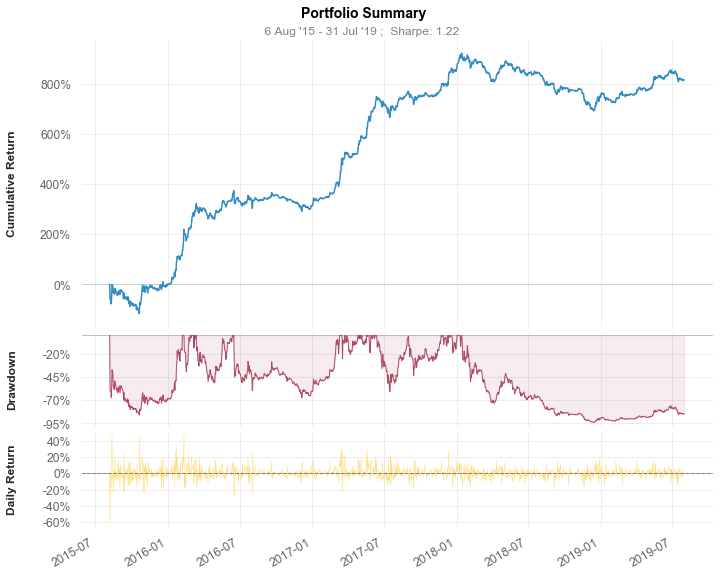

In [6]:
qs.plots.snapshot(temp['returns'])

In [25]:
df_eth = df[df['coin'] == 'ETH']
df_eth = df_eth['close'][df_eth['close'] != 0]
df_eth['returns'] = df_eth.pct_change().fillna(0)

In [43]:
t = pd.DataFrame()
t = pd.concat([t,pd.DataFrame(df_eth['returns'])], axis=1)
t = pd.concat([t,pd.DataFrame(df_btc['returns'])], axis=1)

In [48]:
df['coin'].unique()

array(['BTC', 'ETH', 'AVT', 'OMG', 'EOS', 'LTC', 'USDT', 'XMR', 'DASH',
       'NEO', 'ZEC', 'BTG', 'SNT', 'ETP', 'SAN', 'FUN', 'EDO', 'GNO',
       'TNB', 'BAT', 'TRX', 'HOT', 'GNT', 'BCH', 'XRP', 'ELF', 'ETC',
       'QTUM', 'CND', 'DRGN', 'PAY', 'KNC', 'AST', 'AION', 'UTNP', 'FSN',
       'LSK', 'PAI', 'GUSD', 'RLC', 'MAN', 'UTK', 'ZRX', 'VEE', 'POA',
       'QASH', 'ZIL', 'AGI', 'ZCN', 'BSV', 'XTZ', 'MKR', 'USDC', 'ENJ',
       'WTC', 'DAI', 'LRC', 'ZEN', 'ODE', 'RIF', 'MITH', 'CTXC', 'TKN',
       'REQ', 'BFT', 'MHC', 'ANT', 'EDR', 'RDN', 'DATA', 'THETA', 'REP',
       'XVG', 'MANA', 'CAT', 'ADA', 'BCN', 'NULS', 'GBYTE', 'CVT', 'GRIN',
       'BEAM', 'TNT', 'LINK', 'ICX', 'KIN', 'POWR', 'PHX', 'AMB', 'FUEL',
       'QSP', 'LEND', 'GNX', 'GTO', 'QLC', 'NGC', 'JNT', 'BLZ', 'MOBI',
       'ABT', 'LOOM', 'ONT', 'ELA', 'SKM', 'IOTX', 'EGT', 'QKC', 'MET',
       'NXT', 'BNB', 'KMD', 'WAVES', 'STORJ', 'DGTX', 'DGD', 'EDG', 'AE',
       'XLM', 'XEM', 'DOGE', 'DCR', 'NANO', 'RVN', 'BCD', '

In [44]:
t.sum(axis=1)

time
2014-02-07    0.000000
2014-02-08   -0.067376
2014-02-09    0.016631
2014-02-10   -0.116652
2014-02-11   -0.006299
2014-02-12   -0.082614
2014-02-13   -0.150039
2014-02-14   -0.052632
2014-02-15   -0.132365
2014-02-16   -0.192066
2014-02-17   -0.091795
2014-02-18    0.079587
2014-02-19   -0.110291
2014-02-20   -0.572057
2014-02-21   -0.003217
2014-02-22    1.291054
2014-02-23    0.213545
2014-02-24   -0.439017
2014-02-25   -0.219655
2014-02-26    3.368390
2014-02-27    0.005648
2014-02-28   -0.037804
2014-03-01   -0.028836
2014-03-02   -0.023018
2014-03-03    0.215991
2014-03-04   -0.000498
2014-03-05   -0.005364
2014-03-06   -0.015251
2014-03-07   -0.048638
2014-03-08   -0.012193
2014-03-09    0.029284
2014-03-10   -0.022454
2014-03-11   -0.006982
2014-03-12    0.017644
2014-03-13    0.009057
2014-03-14   -0.017615
2014-03-15    0.016286
2014-03-16   -0.007836
2014-03-17   -0.020609
2014-03-18   -0.012286
2014-03-19   -0.006628
2014-03-20   -0.048692
2014-03-21   -0.028958
2014-0

In [42]:
t.sum(axis=1)

time
2014-02-07    0.000000
2014-02-08   -0.067376
2014-02-09    0.016631
2014-02-10   -0.116652
2014-02-11   -0.006299
2014-02-12   -0.082614
2014-02-13   -0.150039
2014-02-14   -0.052632
2014-02-15   -0.132365
2014-02-16   -0.192066
2014-02-17   -0.091795
2014-02-18    0.079587
2014-02-19   -0.110291
2014-02-20   -0.572057
2014-02-21   -0.003217
2014-02-22    1.291054
2014-02-23    0.213545
2014-02-24   -0.439017
2014-02-25   -0.219655
2014-02-26    3.368390
2014-02-27    0.005648
2014-02-28   -0.037804
2014-03-01   -0.028836
2014-03-02   -0.023018
2014-03-03    0.215991
2014-03-04   -0.000498
2014-03-05   -0.005364
2014-03-06   -0.015251
2014-03-07   -0.048638
2014-03-08   -0.012193
2014-03-09    0.029284
2014-03-10   -0.022454
2014-03-11   -0.006982
2014-03-12    0.017644
2014-03-13    0.009057
2014-03-14   -0.017615
2014-03-15    0.016286
2014-03-16   -0.007836
2014-03-17   -0.020609
2014-03-18   -0.012286
2014-03-19   -0.006628
2014-03-20   -0.048692
2014-03-21   -0.028958
2014-0

In [26]:
df_eth['returns']

time
2015-08-07    0.000000
2015-08-08   -0.600000
2015-08-09    0.000000
2015-08-10    0.000000
2015-08-11   -0.175000
2015-08-12    0.301010
2015-08-13    0.463509
2015-08-14   -0.047745
2015-08-15   -0.002786
2015-08-16   -0.232402
2015-08-17   -0.056769
2015-08-18    0.050926
2015-08-19   -0.089574
2015-08-20    0.227419
2015-08-21   -0.056505
2015-08-22   -0.025070
2015-08-23   -0.035714
2015-08-24   -0.082963
2015-08-25    0.026656
2015-08-26   -0.071597
2015-08-27   -0.037288
2015-08-28    0.139965
2015-08-29   -0.089575
2015-08-30    0.119593
2015-08-31   -0.009848
2015-09-01    0.040551
2015-09-02   -0.161765
2015-09-03    0.082456
2015-09-04    0.094003
2015-09-05    0.014815
2015-09-06   -0.021898
2015-09-07   -0.047761
2015-09-08   -0.010188
2015-09-09   -0.041964
2015-09-10   -0.019835
2015-09-11   -0.220742
2015-09-12    0.239991
2015-09-13   -0.227225
2015-09-14    0.078365
2015-09-15   -0.005236
2015-09-16   -0.014421
2015-09-17   -0.065470
2015-09-18   -0.025943
2015-0

In [28]:
df_eth['returns'] * 0.2 + df_btc['returns'] * 0.8

time
2014-02-07         nan
2014-02-08         nan
2014-02-09         nan
2014-02-10         nan
2014-02-11         nan
2014-02-12         nan
2014-02-13         nan
2014-02-14         nan
2014-02-15         nan
2014-02-16         nan
2014-02-17         nan
2014-02-18         nan
2014-02-19         nan
2014-02-20         nan
2014-02-21         nan
2014-02-22         nan
2014-02-23         nan
2014-02-24         nan
2014-02-25         nan
2014-02-26         nan
2014-02-27         nan
2014-02-28         nan
2014-03-01         nan
2014-03-02         nan
2014-03-03         nan
2014-03-04         nan
2014-03-05         nan
2014-03-06         nan
2014-03-07         nan
2014-03-08         nan
2014-03-09         nan
2014-03-10         nan
2014-03-11         nan
2014-03-12         nan
2014-03-13         nan
2014-03-14         nan
2014-03-15         nan
2014-03-16         nan
2014-03-17         nan
2014-03-18         nan
2014-03-19         nan
2014-03-20         nan
2014-03-21         nan
2014-0

In [27]:
df_btc['returns'] * 0.8 + df_eth['returns'] * 0.2

time
2014-02-07         nan
2014-02-08         nan
2014-02-09         nan
2014-02-10         nan
2014-02-11         nan
2014-02-12         nan
2014-02-13         nan
2014-02-14         nan
2014-02-15         nan
2014-02-16         nan
2014-02-17         nan
2014-02-18         nan
2014-02-19         nan
2014-02-20         nan
2014-02-21         nan
2014-02-22         nan
2014-02-23         nan
2014-02-24         nan
2014-02-25         nan
2014-02-26         nan
2014-02-27         nan
2014-02-28         nan
2014-03-01         nan
2014-03-02         nan
2014-03-03         nan
2014-03-04         nan
2014-03-05         nan
2014-03-06         nan
2014-03-07         nan
2014-03-08         nan
2014-03-09         nan
2014-03-10         nan
2014-03-11         nan
2014-03-12         nan
2014-03-13         nan
2014-03-14         nan
2014-03-15         nan
2014-03-16         nan
2014-03-17         nan
2014-03-18         nan
2014-03-19         nan
2014-03-20         nan
2014-03-21         nan
2014-0

In [22]:
tmp

time
2015-01-21    0.000000
2015-01-22    0.000000
2015-01-23    0.000000
2015-01-24    0.000000
2015-01-25    0.000000
2015-01-26    0.000000
2015-01-27    0.000000
2015-01-28    0.000000
2015-01-29    0.000000
2015-01-30    0.000000
2015-01-31    0.000000
2015-02-01    0.000000
2015-02-02    0.000000
2015-02-03    0.000000
2015-02-04    0.000000
2015-02-05    0.000000
2015-02-06    0.000000
2015-02-07    0.000000
2015-02-08    0.000000
2015-02-09    0.000000
2015-02-10    0.000000
2015-02-11    0.000000
2015-02-12    0.000000
2015-02-13    0.000000
2015-02-14    0.000000
2015-02-15    0.000000
2015-02-16    0.000000
2015-02-17    0.000000
2015-02-18    0.000000
2015-02-19    0.000000
2015-02-20    0.000000
2015-02-21    0.000000
2015-02-22    0.000000
2015-02-23    0.000000
2015-02-24    0.000000
2015-02-25    0.000000
2015-02-26    0.000000
2015-02-27    0.000000
2015-02-28    0.000000
2015-03-01    0.000000
2015-03-02    0.000000
2015-03-03    0.000000
2015-03-04    0.000000
2015-0

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2015-01-21  2015-01-21
End Period                 2019-07-31  2019-07-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      88.0%

Cumulative Return          4,526.37%   70,420.85%
CAGR%                      133.31%     116.46%
Sharpe                     1.26        -0.05
Sortino                    1.89        -0.08
Max Drawdown               -83.29%     -98.69%
Longest DD Days            591         569
Volatility (ann.)          61.58%      157.28%
R^2                        0.15        0.15
Calmar                     1.6         -0.0
Skew                       0.17        1.32
Kurtosis                   4.52        543.7

Expected Daily %           0.23%       0.21%
Expected Monthly %         7.22%       6.56%
Expected Yearly %          115.3%      101.18%
Kelly Criterion            14.16%      19.28%
Risk of Ruin             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2014-02-10,2014-02-16,2014-02-18,8,-1254.853575,-1002.150518
2,2014-02-19,2014-02-20,2014-02-22,3,-818.779926,-238.578666
3,2014-02-23,2014-02-24,2014-02-26,3,-134.004563,-117.013630
4,2014-02-27,2015-01-14,2019-07-31,1980,-107.562474,-103.315653
5,2014-02-07,2014-02-08,2014-02-08,1,0.000000,nan


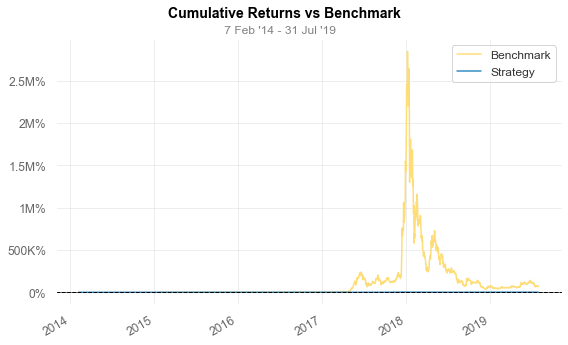

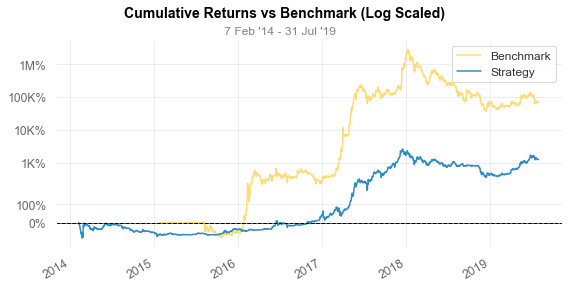

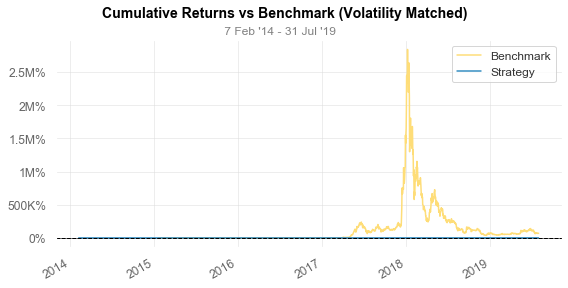

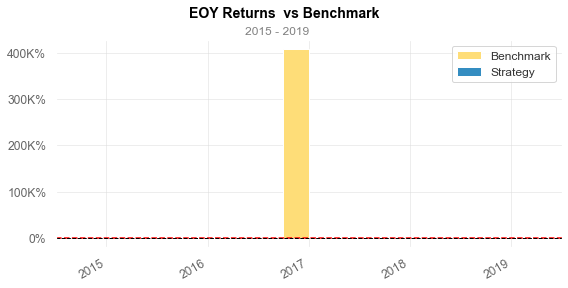

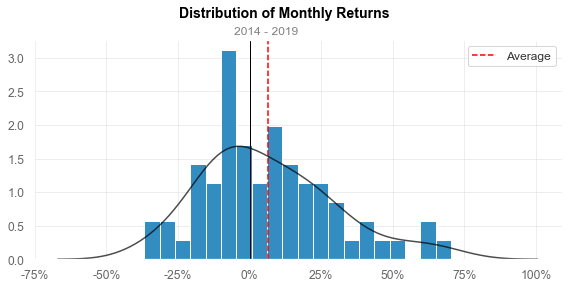

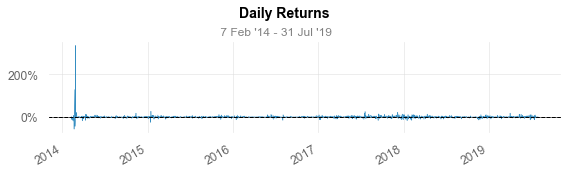

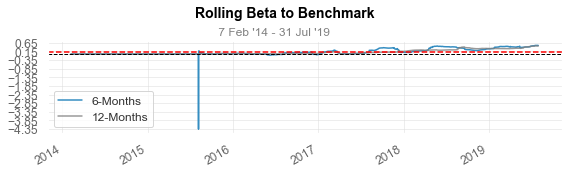

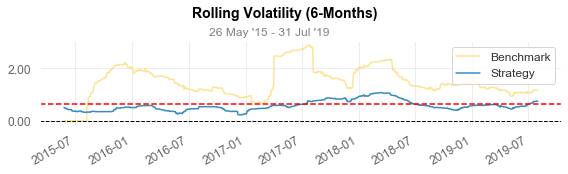

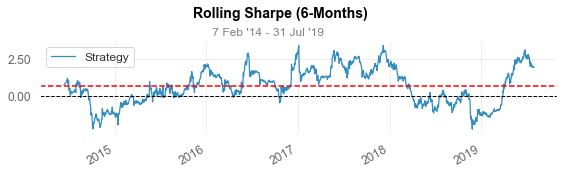

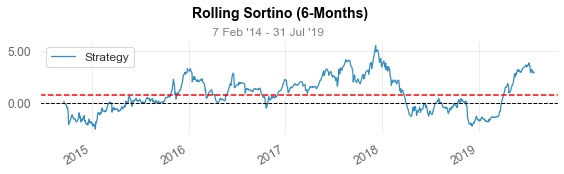

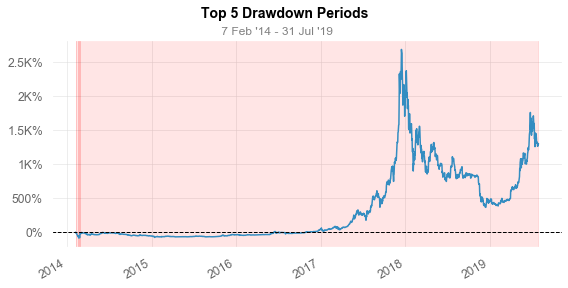

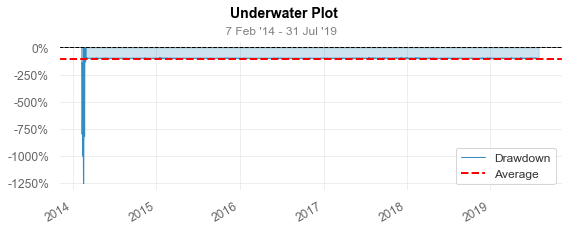

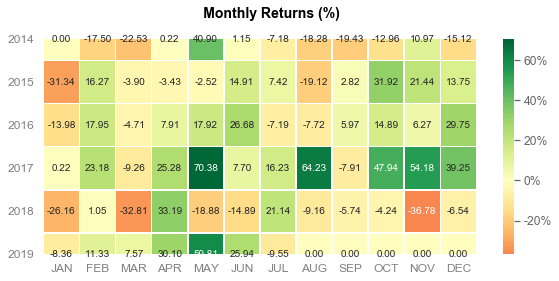

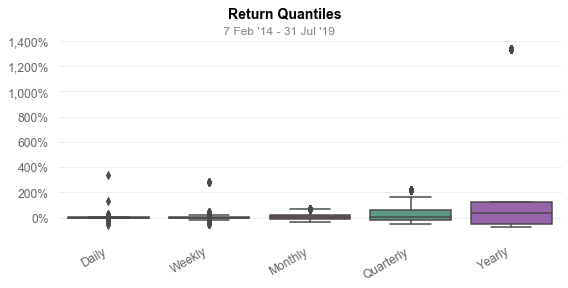

In [21]:
qs.reports.full(df_btc['returns'],tmp)

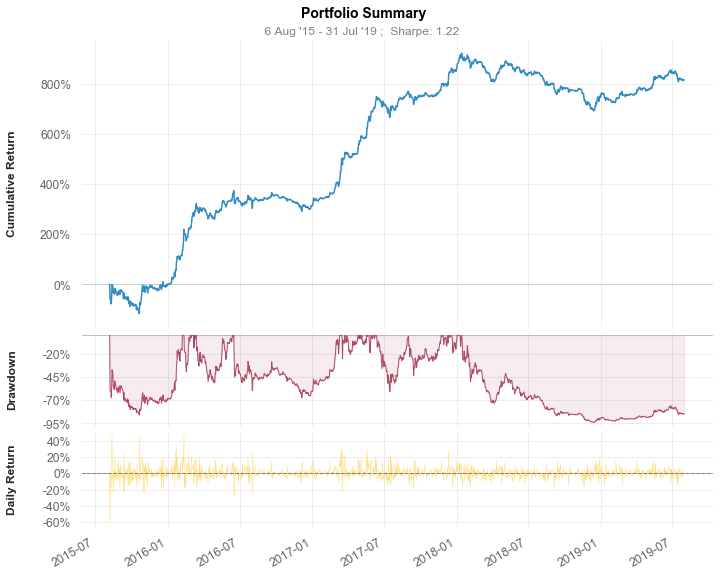

In [7]:
#df = pd.read_csv('test.csv', names=['date', 'price'], index_col=['date'], parse_dates=['date'])[100:]
#df['returns'] = df['price'].pct_change().fillna(0)

qs.plots.snapshot(temp['returns'])

In [10]:
qs.reports.metrics(temp['returns'],"BTC")

ValueError: ('BTC', '1d data not available for startTime=-2208988800 and endTime=1565201925. Only 100 years worth of day granularity data are allowed to be fetched per request.')

In [ ]:
[50,51,52,53]

MA->[50.5,51.5,52.5]

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2015-08-07  2015-08-07
End Period                 2019-07-31  2019-07-31
Risk-Free Rate             0.0%        0.0%
Time in Market             99.0%       100.0%

Cumulative Return          4,931.61%   54.60%
CAGR%                      167.41%     11.56%
Sharpe                     1.4         0.87
Sortino                    2.39        1.21
Max Drawdown               -92.57%     -19.35%
Longest DD Days            567         203
Volatility (ann.)          118.54%     13.67%
R^2                        0.0         0.0
Calmar                     1.81        0.6
Skew                       1.01        -0.45
Kurtosis                   5.3         4.37

Expected Daily %           0.39%       0.04%
Expected Monthly %         8.51%       0.91%
Expected Yearly %          118.95%     9.1%
Kelly Criterion            8.02%       10.0%
Risk of Ruin               0.0%       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-01-14,2018-12-14,2019-07-31,563,-93.942326,-93.464354
2,2015-08-08,2015-10-21,2016-02-08,184,-86.000000,-83.333333
3,2016-06-17,2016-12-05,2017-03-11,267,-67.520621,-65.114022
4,2017-06-13,2017-07-16,2017-11-23,163,-60.619267,-51.864896
5,2016-03-14,2016-04-28,2016-06-12,90,-51.320000,-50.446667


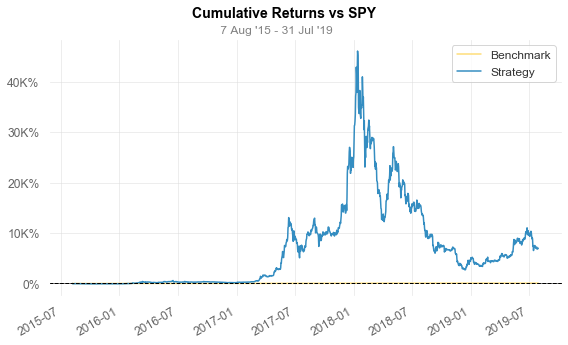

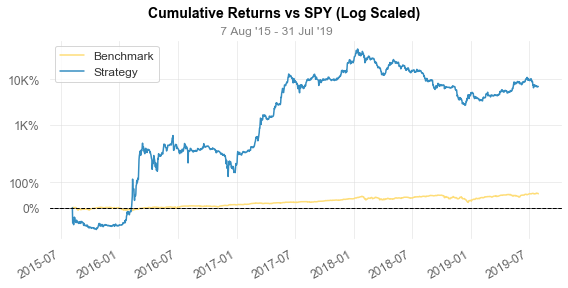

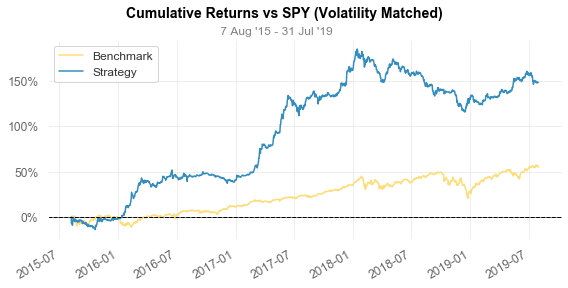

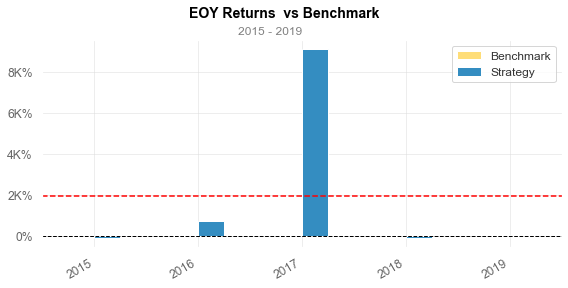

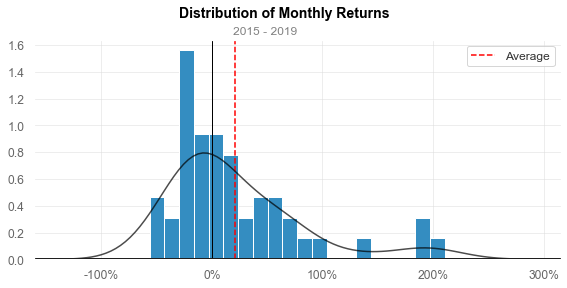

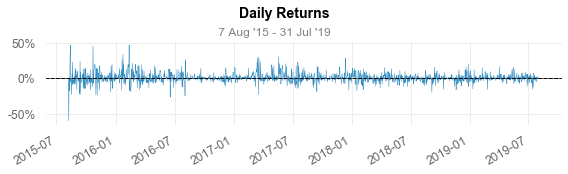

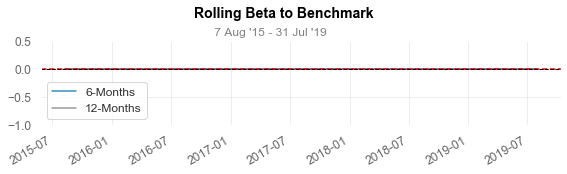

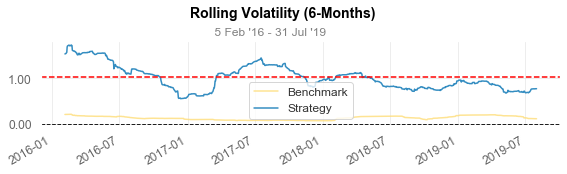

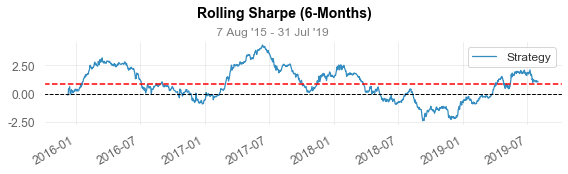

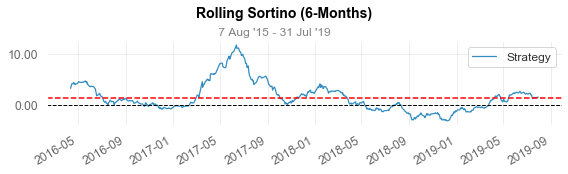

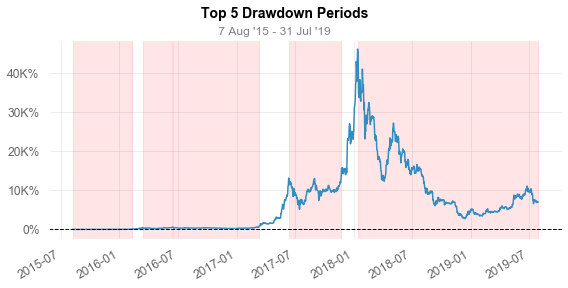

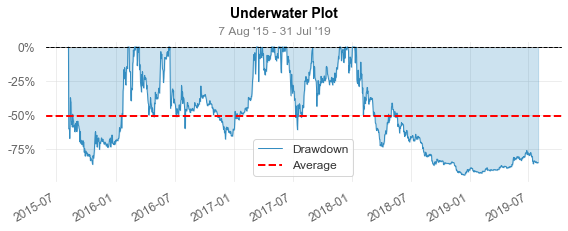

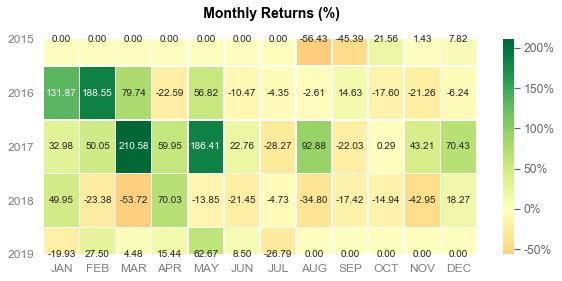

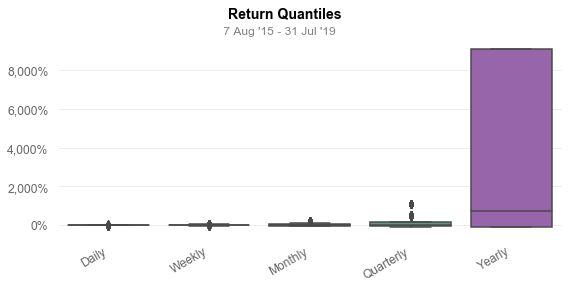

In [14]:
qs.reports.full(temp['returns'], 'SPY' )

In [12]:
import pandas as _pd
import numpy as _np
from datetime import (
    datetime as _dt, timedelta as _td
)
import re as _regex
from tabulate import tabulate as _tabulate
from . import (
    __version__, stats as _stats,
    utils as _utils, plots as _plots
)

try:
    from IPython.core.display import (
        display as iDisplay, HTML as iHTML
    )
except ImportError:
    pass


def html(returns, benchmark=None, rf=0.,
         grayscale=False, title='Strategy Tearsheet',
         file=None, compounded=True):

    if file is None and not _utils._in_notebook():
        raise ValueError("`file` must be specified")

    f = open(__file__[:-4] + '.html')
    tpl = f.read()
    f.close()

    date_range = returns.index.strftime('%e %b, %Y')
    tpl = tpl.replace('{{date_range}}', date_range[0] + ' - ' + date_range[-1])
    tpl = tpl.replace('{{title}}', title)
    tpl = tpl.replace('{{v}}', __version__)

    mtrx = metrics(returns=returns, benchmark=benchmark,
                   rf=rf, display=False, mode='full',
                   sep=True, internal="True",
                   compounded=compounded)[2:]
    mtrx.index.name = 'Metric'
    tpl = tpl.replace('{{metrics}}', _html_table(mtrx))
    tpl = tpl.replace('<tr><td></td><td></td><td></td></tr>',
                      '<tr><td colspan="3"><hr></td></tr>')
    tpl = tpl.replace('<tr><td></td><td></td></tr>',
                      '<tr><td colspan="2"><hr></td></tr>')

    if benchmark is not None:
        yoy = _stats.compare(returns, benchmark, "A", compounded=compounded)
        yoy.columns = ['Benchmark', 'Strategy', 'Multiplier', 'Won']
        yoy.index.name = 'Year'
        tpl = tpl.replace('{{eoy_title}}', '<h3>EOY Returns vs Benchmark</h3>')
        tpl = tpl.replace('{{eoy_table}}', _html_table(yoy))
    else:
        # pct multiplier
        yoy = _pd.DataFrame(
            _utils.group_returns(returns, returns.index.year) * 100)
        yoy.columns = ['Return']
        yoy['Cumulative'] = _utils.group_returns(
            returns, returns.index.year, True)
        yoy['Return'] = yoy['Return'].round(2).astype(str) + '%'
        yoy['Cumulative'] = (yoy['Cumulative'] *
                             100).round(2).astype(str) + '%'
        yoy.index.name = 'Year'
        tpl = tpl.replace('{{eoy_title}}', '<h3>EOY Returns</h3>')
        tpl = tpl.replace('{{eoy_table}}', _html_table(yoy))

    dd = _stats.to_drawdown_series(returns)
    dd_info = _stats.drawdown_details(dd).sort_values(
        by='max drawdown', ascending=True)[:10]

    dd_info = dd_info[['start', 'end', 'max drawdown', 'days']]
    dd_info.columns = ['Started', 'Recovered', 'Drawdown', 'Days']
    tpl = tpl.replace('{{dd_info}}', _html_table(dd_info, False))

    # plots
    figfile = _utils._file_stream()
    _plots.returns(returns, benchmark, grayscale=grayscale,
                   figsize=(8, 5), subtitle=False,
                   savefig={'fname': figfile, 'format': 'svg'},
                   show=False, ylabel=False, cumulative=compounded)
    tpl = tpl.replace('{{returns}}', figfile.getvalue().decode())

    figfile = _utils._file_stream()
    _plots.log_returns(returns, benchmark, grayscale=grayscale,
                       figsize=(8, 4), subtitle=False,
                       savefig={'fname': figfile, 'format': 'svg'},
                       show=False, ylabel=False, cumulative=compounded)
    tpl = tpl.replace('{{log_returns}}', figfile.getvalue().decode())

    if benchmark is not None:
        figfile = _utils._file_stream()
        _plots.returns(returns, benchmark, match_volatility=True,
                       grayscale=grayscale, figsize=(8, 4), subtitle=False,
                       savefig={'fname': figfile, 'format': 'svg'},
                       show=False, ylabel=False, cumulative=compounded)
        tpl = tpl.replace('{{vol_returns}}', figfile.getvalue().decode())

    figfile = _utils._file_stream()
    _plots.yearly_returns(returns, benchmark, grayscale=grayscale,
                          figsize=(8, 4), subtitle=False,
                          savefig={'fname': figfile, 'format': 'svg'},
                          show=False, ylabel=False, compounded=compounded)
    tpl = tpl.replace('{{eoy_returns}}', figfile.getvalue().decode())

    figfile = _utils._file_stream()
    _plots.histogram(returns, grayscale=grayscale,
                     figsize=(8, 4), subtitle=False,
                     savefig={'fname': figfile, 'format': 'svg'},
                     show=False, ylabel=False, compounded=compounded)
    tpl = tpl.replace('{{monthly_dist}}', figfile.getvalue().decode())

    figfile = _utils._file_stream()
    _plots.daily_returns(returns, grayscale=grayscale,
                         figsize=(8, 3), subtitle=False,
                         savefig={'fname': figfile, 'format': 'svg'},
                         show=False, ylabel=False)
    tpl = tpl.replace('{{daily_returns}}', figfile.getvalue().decode())

    if benchmark is not None:
        figfile = _utils._file_stream()
        _plots.rolling_beta(returns, benchmark, grayscale=grayscale,
                            figsize=(8, 3), subtitle=False,
                            savefig={'fname': figfile, 'format': 'svg'},
                            show=False, ylabel=False)
        tpl = tpl.replace('{{rolling_beta}}', figfile.getvalue().decode())

    figfile = _utils._file_stream()
    _plots.rolling_volatility(returns, benchmark, grayscale=grayscale,
                              figsize=(8, 3), subtitle=False,
                              savefig={'fname': figfile, 'format': 'svg'},
                              show=False, ylabel=False)
    tpl = tpl.replace('{{rolling_vol}}', figfile.getvalue().decode())

    figfile = _utils._file_stream()
    _plots.rolling_sharpe(returns, grayscale=grayscale,
                          figsize=(8, 3), subtitle=False,
                          savefig={'fname': figfile, 'format': 'svg'},
                          show=False, ylabel=False)
    tpl = tpl.replace('{{rolling_sharpe}}', figfile.getvalue().decode())

    figfile = _utils._file_stream()
    _plots.rolling_sortino(returns, grayscale=grayscale,
                           figsize=(8, 3), subtitle=False,
                           savefig={'fname': figfile, 'format': 'svg'},
                           show=False, ylabel=False)
    tpl = tpl.replace('{{rolling_sortino}}', figfile.getvalue().decode())

    figfile = _utils._file_stream()
    _plots.drawdowns_periods(returns, grayscale=grayscale,
                             figsize=(8, 4), subtitle=False,
                             savefig={'fname': figfile, 'format': 'svg'},
                             show=False, ylabel=False, compounded=compounded)
    tpl = tpl.replace('{{dd_periods}}', figfile.getvalue().decode())

    figfile = _utils._file_stream()
    _plots.drawdown(returns, grayscale=grayscale,
                    figsize=(8, 3), subtitle=False,
                    savefig={'fname': figfile, 'format': 'svg'},
                    show=False, ylabel=False)
    tpl = tpl.replace('{{dd_plot}}', figfile.getvalue().decode())

    figfile = _utils._file_stream()
    _plots.monthly_heatmap(returns, grayscale=grayscale,
                           figsize=(8, 4), cbar=False,
                           savefig={'fname': figfile, 'format': 'svg'},
                           show=False, ylabel=False, compounded=compounded)
    tpl = tpl.replace('{{monthly_heatmap}}', figfile.getvalue().decode())

    figfile = _utils._file_stream()
    _plots.distribution(returns, grayscale=grayscale,
                        figsize=(8, 4), subtitle=False,
                        savefig={'fname': figfile, 'format': 'svg'},
                        show=False, ylabel=False, compounded=compounded)
    tpl = tpl.replace('{{returns_dist}}', figfile.getvalue().decode())

    tpl = _regex.sub('\{\{(.*?)\}\}', '', tpl)
    tpl = tpl.replace('white-space:pre;', '')

    if file is None:
        # _open_html(tpl)
        _download_html(tpl, 'quantstats-tearsheet.html')
        return

    with open(file, 'w') as file:
        file.write(tpl)


def full(returns, benchmark=None, rf=0., grayscale=False,
         figsize=(8, 5), display=True, compounded=True):

    dd = _stats.to_drawdown_series(returns)
    dd_info = _stats.drawdown_details(dd).sort_values(
        by='max drawdown', ascending=True)[:5]

    if not dd_info.empty:
        dd_info.index = range(1, min(6, len(dd_info)+1))
        dd_info.columns = map(lambda x: str(x).title(), dd_info.columns)

    if _utils._in_notebook():
        iDisplay(iHTML('<h4>Performance Metrics</h4>'))
        iDisplay(metrics(returns=returns, benchmark=benchmark,
                         rf=rf, display=display, mode='full',
                         compounded=compounded))
        iDisplay(iHTML('<h4>5 Worst Drawdowns</h4>'))
        if dd_info.empty:
            iDisplay(iHTML("<p>(no drawdowns)</p>"))
        else:
            iDisplay(dd_info)

        iDisplay(iHTML('<h4>Strategy Visualization</h4>'))
    else:
        print('[Performance Metrics]\n')
        metrics(returns=returns, benchmark=benchmark,
                rf=rf, display=display, mode='full',
                compounded=compounded)
        print('\n\n')
        print('[5 Worst Drawdowns]\n')
        if dd_info.empty:
            print("(no drawdowns)")
        else:
            print(_tabulate(dd_info, headers="keys",
                            tablefmt='simple', floatfmt=".2f"))
        print('\n\n')
        print('[Strategy Visualization]\nvia Matplotlib')

    plots(returns=returns, benchmark=benchmark,
          grayscale=grayscale, figsize=figsize, mode='full')


def basic(returns, benchmark=None, rf=0., grayscale=False,
          figsize=(8, 5), display=True, compounded=True):

    if _utils._in_notebook():
        iDisplay(iHTML('<h4>Performance Metrics</h4>'))
        metrics(returns=returns, benchmark=benchmark,
                rf=rf, display=display, mode='basic',
                compounded=compounded)
        iDisplay(iHTML('<h4>Strategy Visualization</h4>'))
    else:
        print('[Performance Metrics]\n')
        metrics(returns=returns, benchmark=benchmark,
                rf=rf, display=display, mode='basic',
                compounded=compounded)

        print('\n\n')
        print('[Strategy Visualization]\nvia Matplotlib')

    plots(returns=returns, benchmark=benchmark,
          grayscale=grayscale, figsize=figsize, mode='basic')


def metrics(returns, benchmark=None, rf=0., display=True,
            mode='basic', sep=False, compounded=True, **kwargs):

    if isinstance(returns, _pd.DataFrame) and len(returns.columns) > 1:
        raise ValueError("`returns` must be a pandas Series, "
                         "but a multi-column DataFrame was passed")

    if benchmark is not None:
        if isinstance(returns, _pd.DataFrame) and len(returns.columns) > 1:
            raise ValueError("`benchmark` must be a pandas Series, "
                             "but a multi-column DataFrame was passed")


ImportError: cannot import name '__version__' from '__main__' (unknown location)

In [14]:
iDisplay(iHTML('<h4>Performance Metrics</h4>'))
iDisplay(metrics(returns=returns, benchmark=benchmark,
                 rf=rf, display=display, mode='full',
                 compounded=compounded))
iDisplay(iHTML('<h4>5 Worst Drawdowns</h4>'))
if dd_info.empty:
    iDisplay(iHTML("<p>(no drawdowns)</p>"))
else:
    iDisplay(dd_info)

iDisplay(iHTML('<h4>Strategy Visualization</h4>'))

NameError: name 'iDisplay' is not defined